In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/techsoc-analytics-21-22/data/sample_submission.csv
/kaggle/input/techsoc-analytics-21-22/data/train.csv
/kaggle/input/techsoc-analytics-21-22/data/test.csv


In [2]:
!pip install fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 624 kB/s eta 0:00:01
     |████████████████████████████████| 46 kB 3.2 MB/s  eta 0:00:01
     |████████████████████████████████| 51 kB 287 kB/s  eta 0:00:01
     |████████████████████████████████| 112 kB 13.3 MB/s eta 0:00:01
     |████████████████████████████████| 455 kB 13.1 MB/s eta 0:00:01
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 7.0.3
    Uninstalling jupyter-client-7.0.3:
      Successfully uninstalled jupyter-client-7.0.3
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.1.0
    Uninstalling nbconvert-6.1.0:
      Successfully uninstalled nbconvert-6.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.1 requires google-cloud-bigquery-storage, which is not installed.


In [3]:
from fastbook import *
from IPython.display import display,HTML

In [4]:
from fastai.text import *
from fastai.text.all import *
from fastai.text.data import * # specially for textblock

In [5]:
path = Path('/kaggle/input/techsoc-analytics-21-22/data/')

In [6]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')

In [7]:
train.rename(columns = {'content':'text'}, inplace = True)
test.rename(columns = {'content':'text'}, inplace = True)

In [ ]:
train[:2]

In [8]:
df_lm = pd.concat([train, test], axis=0)[['text']]
df_lm.head()

,text
0,"Premium quality five pocket jean from Wrangler Rugged Wear. This Relaxed Fit Jean is made from 100% cotton denim for durability with extra room in the seat and thigh for comfort.\tMen's Wrangler Trail Trekker Relaxed Fit Jeans Set out on a long hike, or kick back for an afternoon full of watching college football from the comfort of your own home. These Wrangler Trail Trekker Relaxed Fit Jeans are up for anything you are! Check 'em out: 100% cotton denim construction; Relaxed 5 pocket style; Easy entry, extra deep front pockets; Solid brass YKK zip fly; Leather waistband patch; Fit easily ..."
1,"If you're looking for a different kind of anime, Sakura Diaries might just fit the bill. It's a clever, quirky romantic comedy spiced up with lots of goofy humor and a splash of R-rated eroticism. Tuoma Inaba is your average country-boy loose in the big city. He arrives in Tokyo to take his college entrance exams, but Tuoma's not too bright and he fails them all. In short order our hero enrolls in a cram school, poses as a student at the prestigious Keio University in order to pursue one beautiful girl, and moves in with another--his cousin Urara who has a huge crush on him. Then things st..."
2,"First things first: Yes, Thinking XXX features adult film stars. No, the HBO production is not a porno. Nor does it include any clips. The documentary instead offers an introduction to the biggest names in the business, like Gina Lynn and Lukas Ridgeston. For his book, XXX - 30 Porn-Star Portraits, celebrity photographer Timothy Greenfield-Saunders shot the stars both clothed and unclothed. In the film, they talk about their work while getting their hair and make-up done, posing for pictures, playing with their pets, etc. They're presented as real people rather than actors (which just may ..."
3,"Feathertouch. 100% Polyester Machine Wash Warm Gentle Cycle, Non Chlorine Bleach, Tumble Dry Low, Low Iron. Imported."
4,"When you need outstanding fuel delivery, easy installation and proper fit, you need ACDelco OES Fuel Pumps the ideal replacement for virtually any GM vehicle on the road today. Manufactured in ISO-9001 and QS-9000 registered facilities, quality is assured and backed by competitive warranty coverage. When you need a high-quality fuel pump rely on ACDelco. Features and Benefits Hybrid Modular Reservoir Assembly (MRA) Latest fuel level sensor design eliminates failures due to worn fingers on sensor wiper arm, sulfur contamination, wire wound sensors and lead sensor kits Improved electrical ..."


In [9]:
dls_lm = DataBlock(
        blocks = TextBlock.from_df('text', is_lm=True),
        get_x = ColReader('text'),
        splitter = RandomSplitter(0.01)
        # use 10% data for validation to learn more
        )

In [10]:
dls_lm = dls_lm.dataloaders(df_lm, bs = 32, seq_len = 72)

In [11]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj for the ultimate experience , sink into the ultra - comfy vistawalker from xxmaj propet . xxmaj whether you 're power - walking or just trying to keep up a fast - paced , active lifestyle , its fully padded interior will keep you feeling good while its traditional design offers an easy , everyday look . \t xxmaj women 's xxmaj propet xxmaj velcro xxmaj vista xxmaj walker available","xxmaj for the ultimate experience , sink into the ultra - comfy vistawalker from xxmaj propet . xxmaj whether you 're power - walking or just trying to keep up a fast - paced , active lifestyle , its fully padded interior will keep you feeling good while its traditional design offers an easy , everyday look . \t xxmaj women 's xxmaj propet xxmaj velcro xxmaj vista xxmaj walker available in"
1,"faucets , flanges , valves and various cylinders . xxmaj they are circular in shape , with a round cross section and a hole in the center , similar to a doughnut . xxmaj o - rings are available in various sizes , and can be ordered based on required nominal inside diameter ( i d ) , outer diameter ( od ) , and cross - sectional ( cs ) diameter",", flanges , valves and various cylinders . xxmaj they are circular in shape , with a round cross section and a hole in the center , similar to a doughnut . xxmaj o - rings are available in various sizes , and can be ordered based on required nominal inside diameter ( i d ) , outer diameter ( od ) , and cross - sectional ( cs ) diameter ."


In [12]:
torch.save(dls_lm, '/kaggle/working/dataloaders_intial.pkl')

In [13]:
dls_lm = torch.load('/kaggle/working/dataloaders_intial.pkl')

In [14]:
learn = language_model_learner(
        dls_lm, AWD_LSTM, drop_mult=0.3,
        metrics=[accuracy]).to_fp16()

/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.010964781977236271)

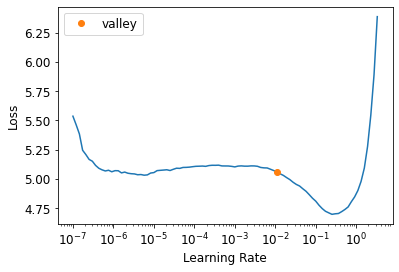

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.491583,2.389601,0.603079,10:02


In [17]:
learn.save('1epoch_initial')

Path('models/1epoch_initial.pth')

In [18]:
learn = learn.load('1epoch_initial')

In [19]:
path

Path('/kaggle/input/techsoc-analytics-21-22/data')

In [20]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.202321,2.156580,0.636796,11:01
1,2.174390,2.037318,0.653987,11:12
2,2.026235,1.906567,0.678824,11:07
3,1.742891,1.803251,0.695891,11:08
4,1.514794,1.747565,0.706412,11:13
5,1.545945,1.672913,0.721973,11:09
6,1.264500,1.627170,0.733131,11:13
7,1.322488,1.604782,0.740960,11:02
8,1.094109,1.596353,0.744030,11:06
9,1.118809,1.599834,0.744872,11:05


In [21]:
# learn.save_encoder('new_finetuned')

In [22]:
# learn.save('new_finetuned')

Path('models/new_finetuned.pth')

In [23]:
path

Path('/kaggle/input/techsoc-analytics-21-22/data')

In [24]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/techsoc-analytics-21-22/data/sample_submission.csv
/kaggle/input/techsoc-analytics-21-22/data/train.csv
/kaggle/input/techsoc-analytics-21-22/data/test.csv


In [25]:
# import shutil
# path = '/kaggle/working/'
# shutil.os.mkdir(path + 'models')

FileExistsError: [Errno 17] File exists: '/kaggle/working/models'

In [ ]:
from distutils.dir_util import copy_tree
from_dir = '/kaggle/input/finetuned-model'
to_dir = '/kaggle/working/models'
copy_tree(from_dir, to_dir)

In [26]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/dataloaders_intial.pkl
/kaggle/working/__notebook_source__.ipynb
/kaggle/working/models/new_finetuned.pth
/kaggle/working/models/1epoch_initial.pth


In [ ]:
# blocks = (TextBlock.from_df('text', seq_len = dls_lm.seq_len, 
#                             vocab = dls_lm.vocab), CategoryBlock())
# dls = DataBlock(blocks = blocks,
#                 get_x = ColReader('text'),
#                 get_y = ColReader('target_ind'),
#                 splitter = RandomSplitter(0.1))

In [ ]:
# dls = dls.dataloaders(train, bs=32) 

In [ ]:
# dls.show_batch(max_n=2)

### learner

In [ ]:
# learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, 
#                                 metrics=accuracy).to_fp16()

In [ ]:
# learn = learn.load_encoder('finetuned')

### fine tuning classifier

In [ ]:
# learn.fit_one_cycle(1, 2e-2)

In [ ]:
# learn.save_encoder('classifier_36_1')
# learn.load_encoder('classifier_36_1')

In [ ]:
# learn.freeze_to(-2)
# learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [ ]:
# learn.freeze_to(-3)
# learn.fit_one_cycle(10, slice(5e-3/(2.6**4),5e-3), cbs=EarlyStoppingCallback(monitor='accuracy'))

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

In [ ]:
# learn.save_encoder('classifier_42')
# learn.load_encoder('classifier_42')

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3))
# epoch	train_loss	valid_loss	accuracy	time
# 0	1.856750	1.808297	0.411279	03:58
# 1	1.850690	1.774235	0.427514	03:59
# 2	1.748285	1.785064	0.421532	03:56
# 3	1.676587	1.722622	0.418114	03:58
# 4	1.629803	1.711791	0.428368	03:58
# 5	1.548868	1.672817	0.424665	03:59

In [ ]:
# learn.save_encoder('classifier_49')